# Experiments HST COSMOS Data Set - Clustering vs. Mean Value Threshold

This noteboook contains the code executed for the experiments performed on the HST COSMOS Data Set to showcase the effects of different image alterations on the entire images and on the detailed regions of the images only. To detect the detailed regions of the images, both the clustering and the mean value threshold methods were implemented.

In [2]:
from PIL import Image, ImageStat, ImageEnhance
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from skimage.metrics import mean_squared_error
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import cm
import glob 
import random
import numpy as np
import os
import cv2
import argparse
import pandas as pd
import math
import torch  
import torch.nn.functional as F 

/var/folders/n2/h_p1g87j4fx1l3clf8fzzls80000gn/T/ipykernel_83139/443326235.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


## Selective SSIM  and SSIM Implementation 



In [2]:
def sssim_func(img1, img2, val_range, weighted_array, window_size=11, k1=0.01, k2=0.03, sigma=1.5):
    
    if img1.shape != img2.shape:
        print("ValueError: differently sized input images")
        return None
    
    if window_size % 2 == 0:
        print("ValueError: window size is not odd")
        return None
        
    try:
        _, img_channels, height, width = img1.size()
    except:
        img_channels, height, width = img1.size()
    
    # we set L to be the dynamic range of pixel values
    L = val_range 
    # we define the padding size for the sliding window
    pad = window_size // 2
    
    # initialize sliding window
    # 1d tensor
    window_1d = torch.Tensor(np.exp(-(np.arange(window_size) - window_size//2)**2/float(2*sigma**2)))
    window_1d /= window_1d.sum()
    window_1d = window_1d.unsqueeze(1)

    # convert to 2d
    window_2d = torch.Tensor(np.outer(window_1d, window_1d)).unsqueeze(0).unsqueeze(0)
    
    window = torch.Tensor(window_2d.expand(img_channels, 1, window_size, window_size).contiguous())
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=img_channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=img_channels)

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=img_channels) - mu1**2
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=img_channels) - mu2**2
    sigma_12 =  F.conv2d(img1 * img2, window, padding=pad, groups=img_channels) - mu1*mu2

    # Define stability constants
    C1 = k1 ** 2  
    C2 = k2 ** 2 

    num1 = 2 * mu1*mu2 + C1  
    num2 = 2 * sigma_12 + C2
    denom1 = mu1**2 + mu2**2 + C1 
    denom2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (num1 * num2) / (denom1 * denom2)    
    weighted_ssim_score = torch.mul(weighted_array,ssim_score)

    return torch.sum(weighted_ssim_score) / torch.sum(weighted_array)

def ssim_func(img1, img2, val_range, window_size=11, k1=0.01, k2=0.03, sigma=1.5):
    """
    Calculates the SSIM Index between two images img1 and img2.
    
    Parameters: 
        img1 (ndarray): First input image, numpy array.
        img2 (ndarray): Second input image, numpy array.
        weighted_array (ndarray): Weighted array in the shape of the input images.
        val_range (float): Range of the pixel values, is 255.0 for 8-bit grayscale images.
        window_size (int): Sliding window size, must be an odd number. 
        k1 (float): Numerical stability constant.
        k2 (float): Numerical stability constant.
        sigma (float): standard deviation of Gaussian kernel.
    
    """
    
    if img1.shape != img2.shape:
        print("ValueError: differently sized input images")
        return None
    
    if window_size % 2 == 0:
        print("ValueError: window size is not odd")
        return None
        
    try:
        _, img_channels, height, width = img1.size()
    except:
        img_channels, height, width = img1.size()
    
    # we set L to be the dynamic range of pixel values
    L = val_range 
    # we define the padding size for the sliding window
    pad = window_size // 2
    
    # initialize sliding window
    # 1d tensor
    window_1d = torch.Tensor(np.exp(-(np.arange(window_size) - window_size//2)**2/float(2*sigma**2)))
    window_1d /= window_1d.sum()
    window_1d = window_1d.unsqueeze(1)

    # convert to 2d
    window_2d = torch.Tensor(np.outer(window_1d, window_1d)).unsqueeze(0).unsqueeze(0)
    
    window = torch.Tensor(window_2d.expand(img_channels, 1, window_size, window_size).contiguous())
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=img_channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=img_channels)

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=img_channels) - mu1**2
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=img_channels) - mu2**2
    sigma_12 =  F.conv2d(img1 * img2, window, padding=pad, groups=img_channels) - mu1*mu2

    # Define stability constants
    C1 = k1 ** 2  
    C2 = k2 ** 2 

    num1 = 2 * mu1*mu2 + C1  
    num2 = 2 * sigma_12 + C2
    denom1 = mu1**2 + mu2**2 + C1 
    denom2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (num1 * num2) / (denom1 * denom2)    
    
    return ssim_score.mean()

In [5]:
# show different background detections on example image
for filename in glob.glob('/home/julia/temp/*.fits'):
    if filename == '/home/julia/temp/20042790.fits':
        # load image
        image_file = get_pkg_data_filename(filename)
        imarray = fits.getdata(image_file, ext=0)
        imarray = imarray.astype(np.float32)
        max_val = np.max(imarray)
        if max_val != 0:
            imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
            imarray = imarray.numpy()

        # create array that has brightness value for each pixel 
        data = imarray.flatten()
        data = data.reshape(-1,1)
        kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
        kmeans.fit(data)
        df = pd.DataFrame({'brightness': imarray.flatten(),
                           'label': kmeans.labels_})
    
        if len(np.unique(kmeans.labels_)) == 1:
            continue 
        
        background_label = df.loc[df['brightness'].idxmin()]['label']
        data = data.reshape(imarray.shape)
        labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
        background_array = 1 * (labels == background_label)
        detailed_array = 1*(labels != background_label)
        weighted_array = detailed_array
        
        
        imarray_saved = (((weighted_array - weighted_array.min()) / (weighted_array.max() - weighted_array.min())) * 255.9).astype(np.uint8)
        img = Image.fromarray(imarray_saved)
        img.save("clustering_background.png")
        
        boolean_array = 1*(imarray > imarray.mean())
        background_array = 1*(imarray <= imarray.mean())
        segmented_im = imarray * boolean_array
        background_im = imarray * background_array
        # create weighted array in right shape
        weighted_array = boolean_array
        
        imarray_saved = (((weighted_array - weighted_array.min()) / (weighted_array.max() - weighted_array.min())) * 255.9).astype(np.uint8)
        img = Image.fromarray(imarray_saved)
        img.save("mean_val_background.png")
    


### Implementation of function to normalize images

In [3]:
def normalize_image(image, max_val):
    image = torch.clamp(image, min=0.0, max=max_val)

    # Normalize the image
    image = image / max_val

    # Clip the final image in order to prevent rounding errors
    image = torch.clamp(image, min=0.0, max=1.0)

    return image

## Backrground Detection with Clustering Method

In [4]:
# compare ssim values

def normalize(image, max_val):
    image = np.clip(image, a_min=0.0, a_max=max_val)

    # Normalize the image
    image = image / max_val

    # Clip the final image in order to prevent rounding errors
    image = np.clip(image, a_min=0.0, a_max=1.0)

    return image


ind = 0

background_percentage = []
ssim_counter = 0

for filename in glob.glob('/home/julia/temp/*.fits'):
    print(ind)
    # load image
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val == 0:
        ssim_counter += 1
        continue
    imarray = normalize(imarray, max_val)
    # create array that has brightness value for each pixel 
    data = imarray.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': imarray.flatten(),
                           'label': kmeans.labels_})
    if len(np.unique(kmeans.labels_)) == 1:
        ssim_counter += 1
        continue
    
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(imarray.shape)
    labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    background_portion = np.count_nonzero(background_array)
    detailed_portion = np.count_nonzero(detailed_array)
    background_percentage.append(background_portion/(background_portion+detailed_portion))

    
    ind += 1

print("Mean background percentage: ", np.mean(background_percentage))
print("Discarded Images: ", ssim_counter)

0
1
2
3
4
5
6
7
8
9
10
11
12
12
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
27
28
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
115
116
117
118
119
119
120
121
122
123
124
125
126
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
187
188
189
189
190
191
192
193
194
195
196
197
198
199
199
199
200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


## Background Detection with Mean Value Threshold Method


In [7]:
ind = 0

background_percentage = []
ssim_counter = 0

min_pixel_vals = []
max_pixel_vals = []

for filename in glob.glob('/home/julia/temp/*.fits'):
    print(ind)
    # load image
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    min_val = np.min(imarray)
    min_pixel_vals.append(min_val)
    max_pixel_vals.append(max_val)
    
    if max_val == 0:
        ssim_counter += 1
        continue
    imarray = normalize(imarray, max_val)
    
    # segment image by creating np.array that has 1s wherever 
    # the pixel value is above image pixel mean for detailed area
    boolean_array = 1*(imarray > imarray.mean())
    background_array = 1*(imarray <= imarray.mean())
    # create weighted array in right shape
    detailed_array = boolean_array
    
    if np.count_nonzero(detailed_array) == 0:
        ssim_counter += 1
        continue
        
    background_portion = np.count_nonzero(background_array)
    detailed_portion = np.count_nonzero(detailed_array)
    background_percentage.append(background_portion/(background_portion+detailed_portion))
    
    ind += 1

print("Mean background percentage: ", np.mean(background_percentage))
print("Discarded Images: ", ssim_counter)
print("Min pixel val:", np.min(min_pixel_vals))
print("Max pixel val:", np.max(max_pixel_vals))

0
1
2
3
4
5
6
7
8
9
10
11
12
12
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
27
28
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
115
116
117
118
119
119
120
121
122
123
124
125
126
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
187
188
189
189
190
191
192
193
194
195
196
197
198
199
199
199
200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


## Background Detection on 2D Data Set - Clustering


### Blurring

0


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


50


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


100


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


150


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


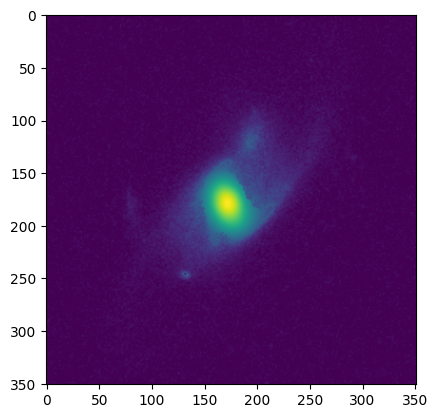

SSIM value:  tensor(0.9988)
Selecive SSIM value:  tensor(0.9497)
200


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


250


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


300
350


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


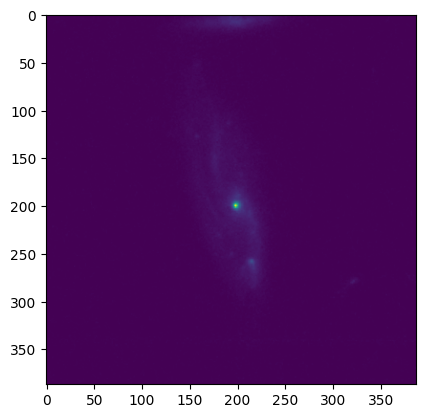

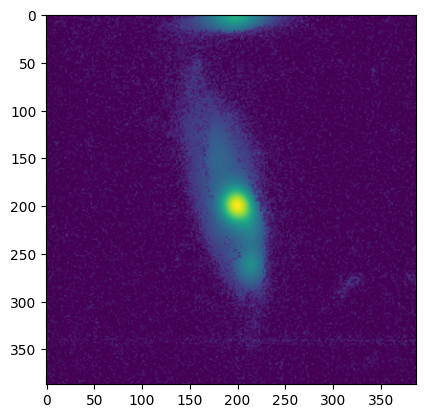

SSIM value:  tensor(0.9972)
Selecive SSIM value:  tensor(0.9586)
400


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


450


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


500


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


550


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


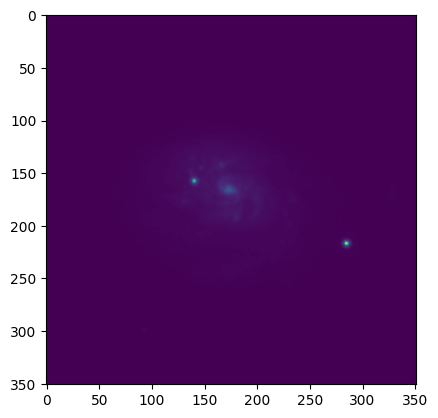

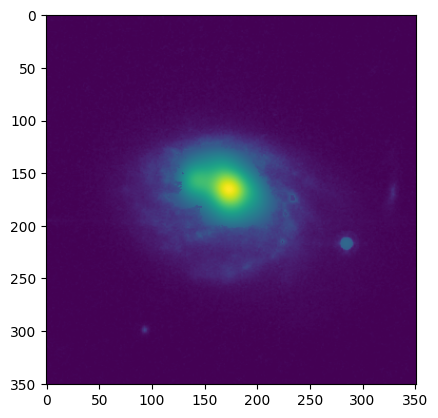

SSIM value:  tensor(0.9980)
Selecive SSIM value:  tensor(0.9588)
600
650
700


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


750


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


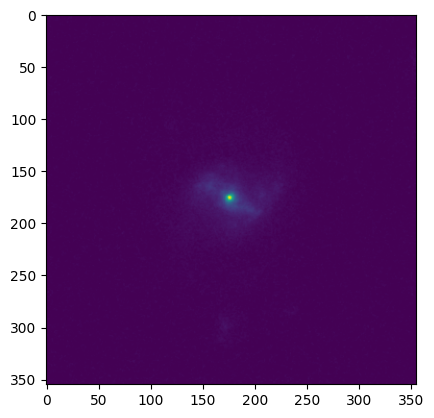

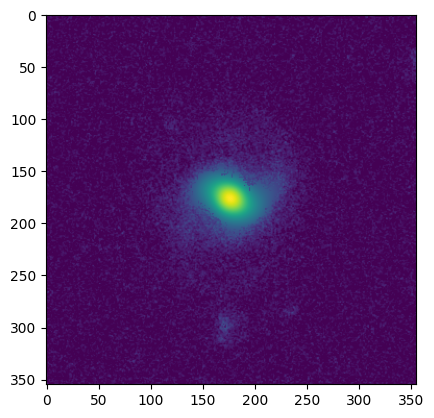

SSIM value:  tensor(0.9985)
Selecive SSIM value:  tensor(0.9442)
800


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


850


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


900
950


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


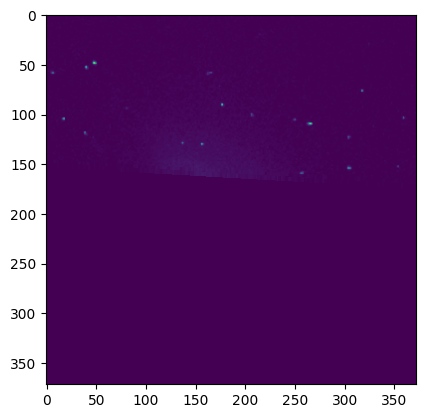

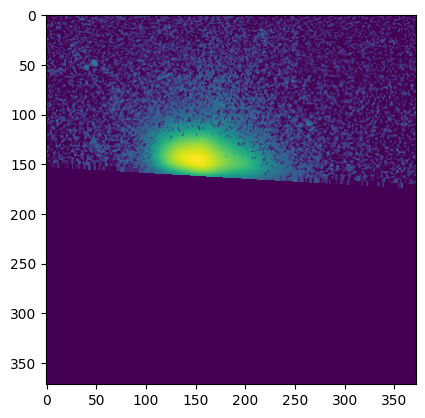

SSIM value:  tensor(0.9956)
Selecive SSIM value:  tensor(0.9397)
1000


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


1050


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


1100


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


1150


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


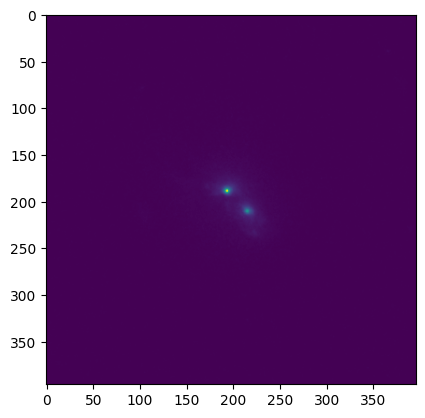

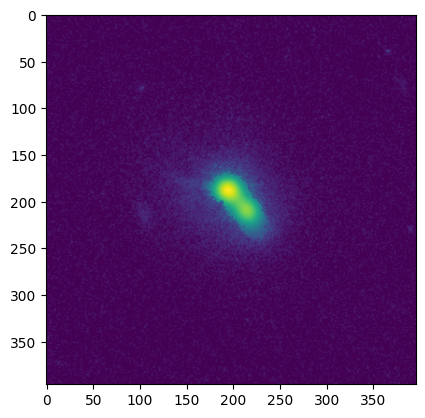

SSIM value:  tensor(0.9986)
Selecive SSIM value:  tensor(0.9078)
1200


/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_247713/304361071.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


1250
Distribution of SSIM values:
Max SSIM value:  0.9998744
Min SSIM value:  0.90477866
Mean SSIM value:  0.99706304
Distribution of SSSIM values:
Max SSSIM value:  0.9893186
Min SSSIM value:  0.0028463658
Mean SSSIM value:  0.8411774


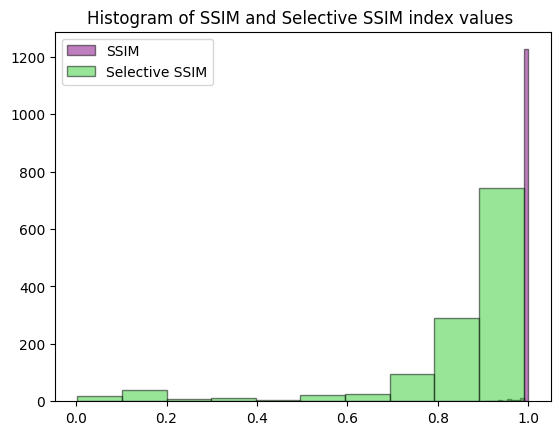

In [4]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.fits'):
    # load image
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val != 0:
        imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
        imarray = imarray.numpy()

    # create array that has brightness value for each pixel 
    data = imarray.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': imarray.flatten(),
                           'label': kmeans.labels_})
    
    if len(np.unique(kmeans.labels_)) == 1:
        continue 
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(imarray.shape)
    labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    weighted_array = detailed_array

    # create blurred image in detailed areas 
    blurred = gaussian_filter(imarray, sigma=10) * detailed_array + imarray * background_array
    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    blurred = blurred.reshape(blurred.shape[0], blurred.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray), 
                         torch.Tensor(blurred), 
                         val_range=np.max(blurred)-np.min(blurred)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                    torch.Tensor(blurred), 
                                    val_range=np.max(blurred)-np.min(blurred), 
                                    weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))
    
    ssim_vals_full.append(ssim_val)
    ssim_vals_selected.append(ssim_val_selected)
    
    if ind in [200, 400, 600, 800, 1000, 1200]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(blurred)
        plt.show()
        
        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    if ind % 50 == 0:
        print(ind)
    ind += 1



print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full, alpha=0.5, color='purple', edgecolor='black', label='SSIM')
plt.hist(ssim_vals_selected, alpha=0.5, color='limegreen', edgecolor='black', label='Selective SSIM')
plt.title("Histogram of SSIM and Selective SSIM index values ")
plt.legend()
#plt.savefig("clustering_adjusted_ssim_blurring.png")


# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals_full)
ssim_blurred_df.to_csv('2d_ssim_blurred.csv') 
sssim_blurred_df = pd.DataFrame(ssim_vals_selected)
sssim_blurred_df.to_csv('2d_sssim_blurred.csv') 


In [ ]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

zero_array = 0

for filename in glob.glob('/home/julia/*.fits'):
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val != 0:
        imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
        imarray = imarray.numpy()
    
    # segment image by creating np.array that has 1s wherever 
    # at least one of RGB values is above image pixel mean for detailed are
    # and creating np.array that has 1s whereever all RGB values are below threshold
    boolean_array = 1*(imarray > imarray.mean())
    background_array = 1*(imarray <= imarray.mean())
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array
    
    if np.count_nonzero(weighted_array) == 0:
        zero_array += 1
        continue
        
    
    # create blurred image by applying gaussian blur to pixels where at least one RGB value is above threshold
    # and merging it with regular background pixels in areas where all RGB values are below threshold
    blurred = gaussian_filter(imarray, sigma=10) * boolean_array + background_im
    
    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    blurred = blurred.reshape(blurred.shape[0], blurred.shape[1], 1)
    # calculate different ssim values
    ssim_val_full = ssim_func(torch.Tensor(imarray),
                              torch.Tensor(blurred), 
                              val_range=np.max(blurred)-np.min(blurred))   
    ssim_vals_full.append(ssim_val_full)
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                   torch.Tensor(blurred), 
                                   val_range=np.max(blurred)-np.min(blurred), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))
    ssim_vals_selected.append(ssim_val_selected)

    if ind in [200, 600, 1200, 2000]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(blurred)
        plt.show()

        print("SSIM value: ", ssim_val_full)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    ind += 1

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals_full)
ssim_blurred_df.to_csv('2d_ssim_blurred_mean_val.csv') 
sssim_blurred_df = pd.DataFrame(ssim_vals_selected)
sssim_blurred_df.to_csv('2d_sssim_blurred_mean_val.csv') 

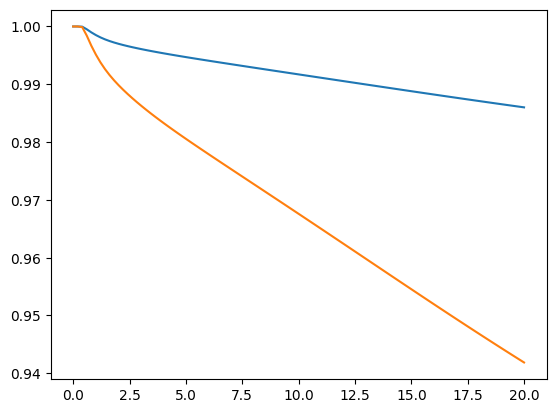

In [5]:
filename = '/home/julia/20005425.fits'

ssim_vals = []
sssim_vals = []

gaussian_blur = np.linspace(0,20,100)

# load image 
image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()

# create array that has brightness value for each pixel 
data = imarray.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
kmeans.fit(data)
df = pd.DataFrame({'brightness': imarray.flatten(),
                   'label': kmeans.labels_})
        
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(imarray.shape)
labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
background_array = 1 * (labels == background_label)

detailed_array = 1*(labels != background_label)

weighted_array = detailed_array

# create blurred image in detailed areas 
for blur in gaussian_blur:
    blurred = gaussian_filter(imarray, sigma=blur) * detailed_array + imarray * background_array

    imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    blurred = blurred.reshape(blurred.shape[0], blurred.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray_temp), 
                         torch.Tensor(blurred), 
                         val_range=np.max(blurred)-np.min(blurred)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                   torch.Tensor(blurred),
                                   val_range=np.max(blurred)-np.min(blurred), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))


    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(gaussian_blur, ssim_vals)
plt.plot(gaussian_blur, sssim_vals)

# save values in csv files
ssim_blurred_example_df = pd.DataFrame(ssim_vals)
ssim_blurred_example_df.to_csv('2d_ssim_blurred_exp.csv') 
sssim_blurred_example_df = pd.DataFrame(sssim_vals)
sssim_blurred_example_df.to_csv('2d_sssim_blurred_exp.csv') 



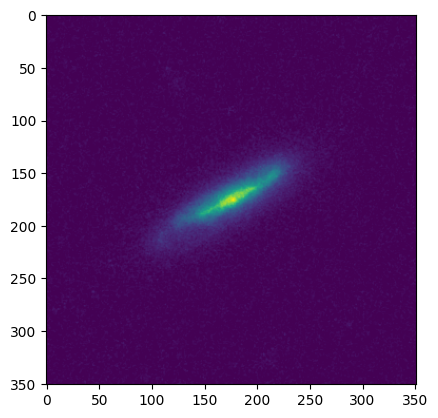

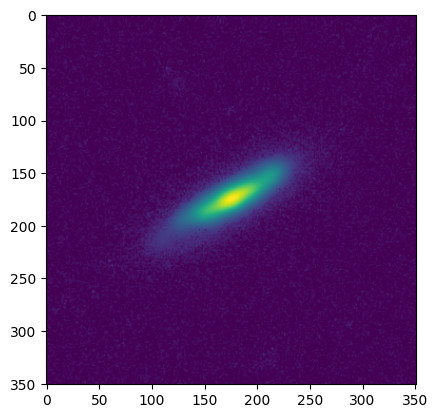

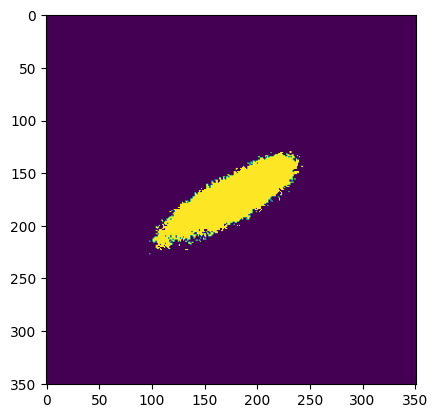

tensor(0.9812)
tensor(0.9992)


True

In [24]:
# saving figure of blur applied only to detailed area and still achieving a high SSIM score
filename = '/home/julia/20042790.fits'
#filename = '/home/julia/20023391.fits'

# load image 
image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()

# create array that has brightness value for each pixel 
data = imarray.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
kmeans.fit(data)
df = pd.DataFrame({'brightness': imarray.flatten(),
                   'label': kmeans.labels_})
        
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(imarray.shape)
labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
background_array = 1 * (labels == background_label)

detailed_array = 1*(labels != background_label)

weighted_array = detailed_array

# create blurred image in detailed areas 

blurred = gaussian_filter(imarray, sigma=5) * detailed_array + imarray * background_array

imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
blurred = blurred.reshape(blurred.shape[0], blurred.shape[1], 1)
# calculate different ssim scores
ssim_val = ssim_func(torch.Tensor(imarray_temp), 
                    torch.Tensor(blurred), 
                    val_range=np.max(blurred)-np.min(blurred)) 
ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                torch.Tensor(blurred),
                                val_range=np.max(blurred)-np.min(blurred), 
                                weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

plt.figure()
plt.imshow(imarray)
plt.show()
plt.figure()
plt.imshow(blurred)
plt.show()
plt.imshow(detailed_array)
plt.show()

print(ssim_val_selected)
print(ssim_val)

# save images
norm_image = cv2.normalize(imarray, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)
cv2.imwrite("original_20042790.png", norm_image)
blurred_image = cv2.normalize(blurred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
blurred_image = blurred_image.astype(np.uint8)
cv2.imwrite("blurred_sd5_20042790.png", blurred_image)

detailed_image = cv2.normalize(detailed_array, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
detailed_image = detailed_image.astype(np.uint8)
cv2.imwrite("background_20042790.png", detailed_image)


### Sharpening

/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct cl

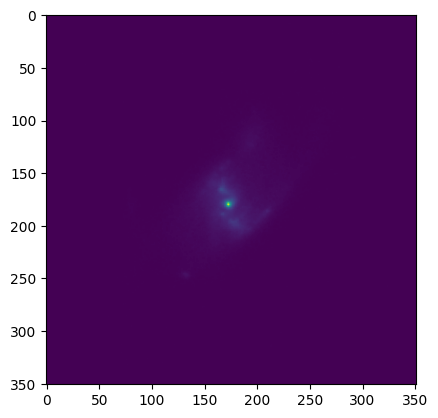

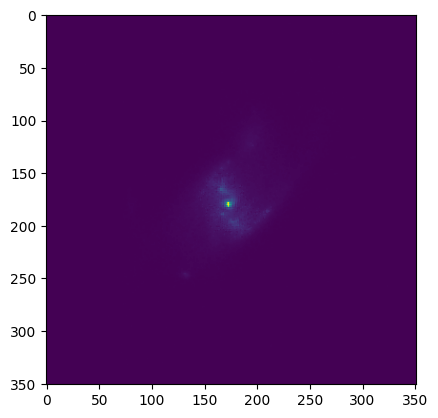

SSIM value:  tensor(0.9997)
Selecive SSIM value:  tensor(0.9893)


/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


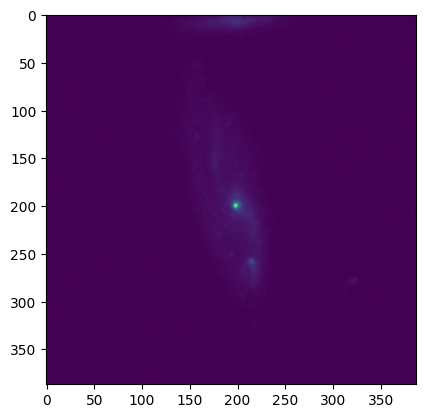

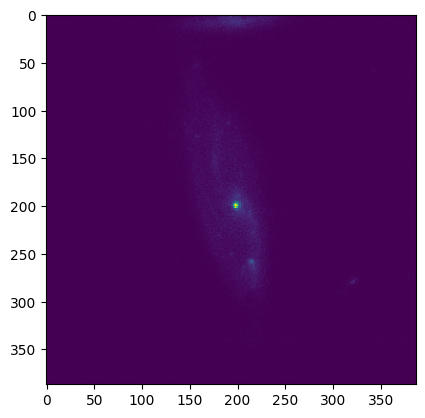

SSIM value:  tensor(0.9966)
Selecive SSIM value:  tensor(0.9585)


/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct cl

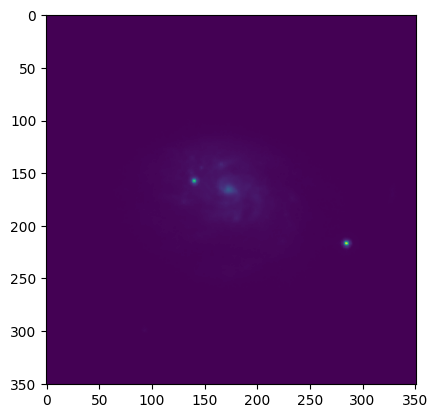

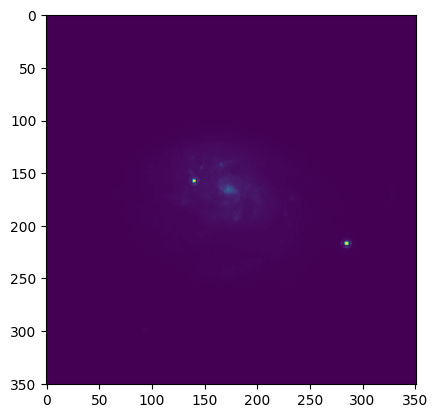

SSIM value:  tensor(0.9994)
Selecive SSIM value:  tensor(0.9896)


/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


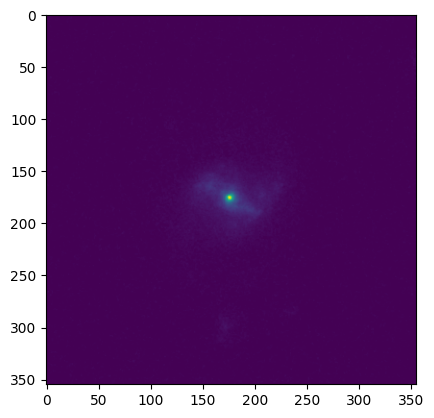

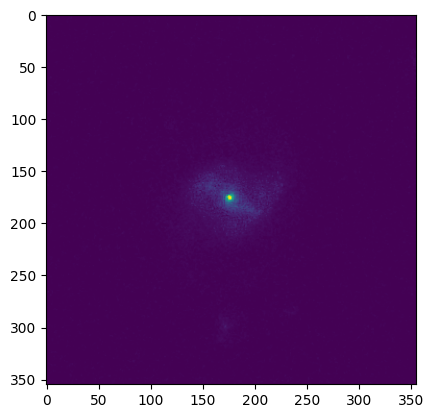

SSIM value:  tensor(0.9991)
Selecive SSIM value:  tensor(0.9735)


/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct cl

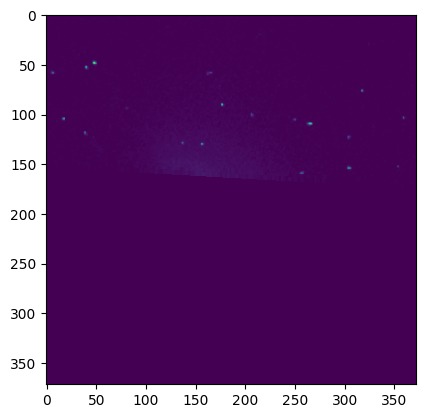

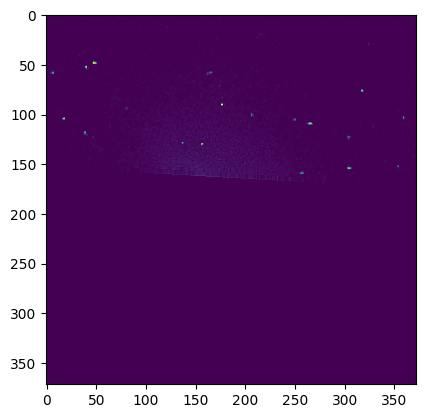

SSIM value:  tensor(0.9849)
Selecive SSIM value:  tensor(0.8677)


/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct cl

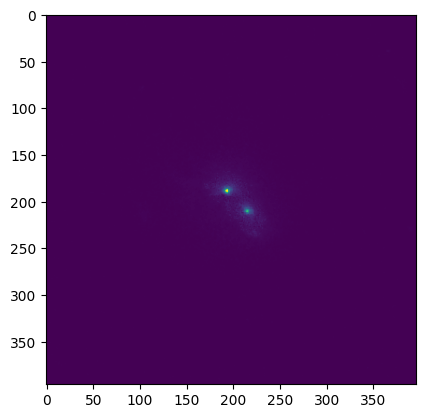

SSIM value:  tensor(0.9997)
Selecive SSIM value:  tensor(0.9791)


/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_74440/3966291496.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


Distribution of SSIM values:
Max SSIM value:  0.99998796
Min SSIM value:  0.7519227
Mean SSIM value:  0.99489397
Distribution of SSSIM values:
Max SSSIM value:  0.9974747
Min SSSIM value:  0.570138
Mean SSSIM value:  0.9569471


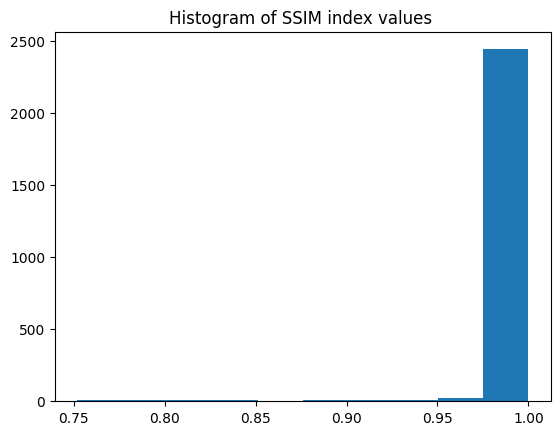

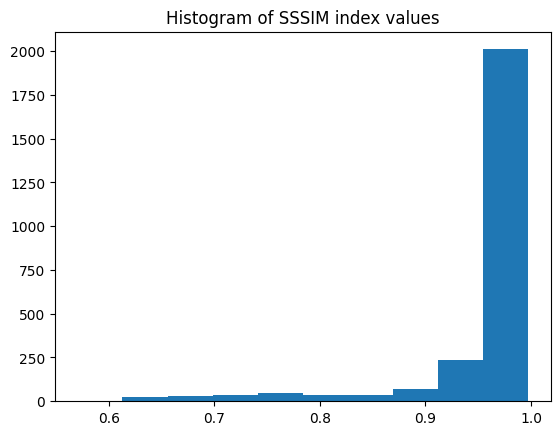

In [21]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.fits'):
    # load image
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val != 0:
        imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
        imarray = imarray.numpy()

    # create array that has brightness value for each pixel 
    data = imarray.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': imarray.flatten(),
                           'label': kmeans.labels_})
    
    if len(np.unique(kmeans.labels_)) == 1:
        continue
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(imarray.shape)
    labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    weighted_array = detailed_array

    # create sharpened image in detailed areas 
    #im = Image.fromarray(np.uint8(cm.gist_earth(imarray)*255))
    im = Image.fromarray(np.uint8(imarray * 255) , 'L')
    imarray = np.array(im)

    enhancer = ImageEnhance.Sharpness(im)
    factor = 5
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * detailed_array + imarray * background_array

    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    sharpened = sharpened.reshape(sharpened.shape[0], sharpened.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray), 
                         torch.Tensor(sharpened), 
                         val_range=np.max(sharpened)-np.min(sharpened)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                   torch.Tensor(sharpened), 
                                   val_range=np.max(sharpened)-np.min(sharpened), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

    ssim_vals_selected.append(ssim_val_selected)
    ssim_vals_full.append(ssim_val)

    if ind in [200, 400, 600, 800, 1000, 1200]:
        plt.figure()
        plt.imshow(im)
        plt.show()
        plt.figure()
        plt.imshow(sharpened)
        plt.show()

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)

        
    ssim_vals_full.append(ssim_val)
    ssim_vals_selected.append(ssim_val_selected)
    
    ind += 1

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

# save values in csv files
ssim_sharpened_df = pd.DataFrame(ssim_vals_full)
ssim_sharpened_df.to_csv('2d_ssim_sharpened.csv') 
sssim_sharpened_df = pd.DataFrame(ssim_vals_selected)
sssim_sharpened_df.to_csv('2d_sssim_sharpened.csv') 


In [6]:
filename = '/home/julia/20005425.fits'

ssim_vals = []
sssim_vals = []

sharpness = np.linspace(0,10,100)
# load image
image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()

# create array that has brightness value for each pixel 
data = imarray.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
kmeans.fit(data)
df = pd.DataFrame({'brightness': imarray.flatten(),
                    'label': kmeans.labels_})
    
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(imarray.shape)
labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
background_array = 1 * (labels == background_label)
detailed_array = 1*(labels != background_label)
weighted_array = detailed_array

im = Image.fromarray(np.uint8(imarray * 255) , 'L')
imarray = np.array(im)
enhancer = ImageEnhance.Sharpness(im)

for s in sharpness:
    factor = s
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * detailed_array + imarray * background_array
       
    imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    sharpened = sharpened.reshape(sharpened.shape[0], sharpened.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray_temp), 
                         torch.Tensor(sharpened), 
                         val_range=np.max(sharpened)-np.min(sharpened)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                   torch.Tensor(sharpened), 
                                   val_range=np.max(sharpened)-np.min(sharpened), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)

plt.plot(sharpness, ssim_vals)
plt.plot(sharpness, sssim_vals)

# save values in csv files
ssim_sharpened_example_df = pd.DataFrame(ssim_vals)
ssim_sharpened_example_df.to_csv('2d_ssim_sharp_exp.csv') 
sssim_sharpened_example_df = pd.DataFrame(sssim_vals)
sssim_sharpened_example_df.to_csv('2d_sssim_sharp_exp.csv') 


### Adding Pixel Values

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct cl

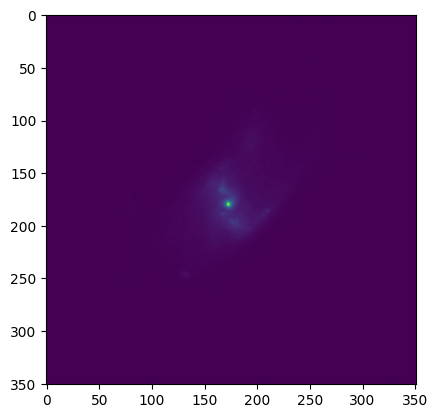

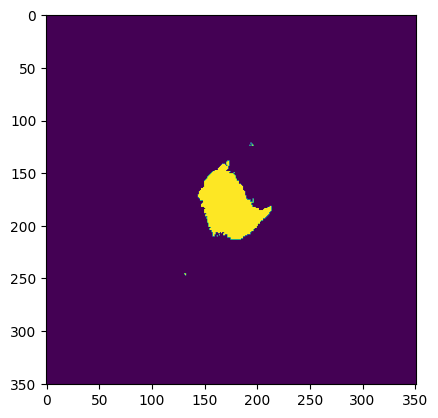

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


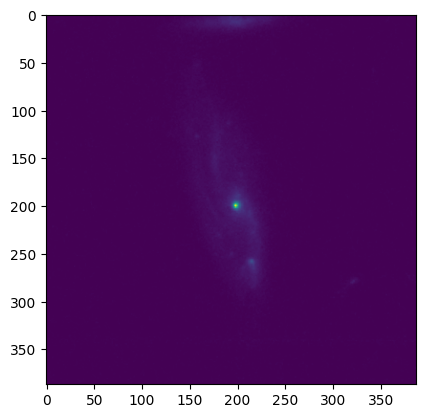

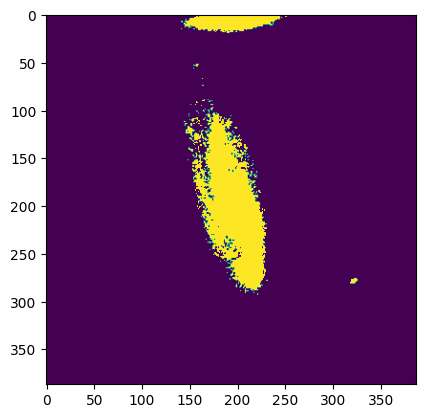

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct cl

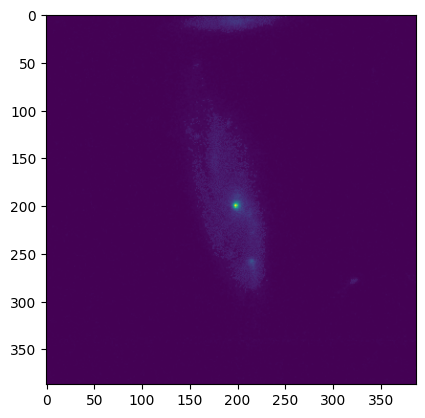

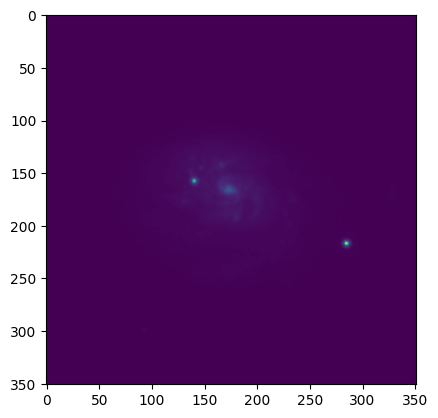

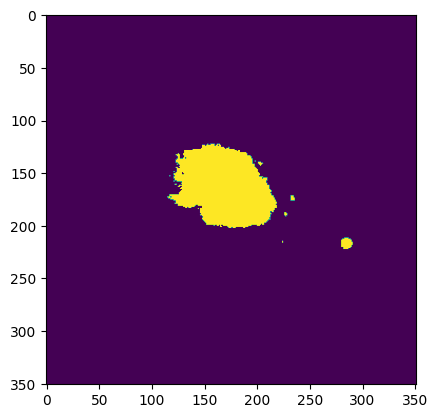

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


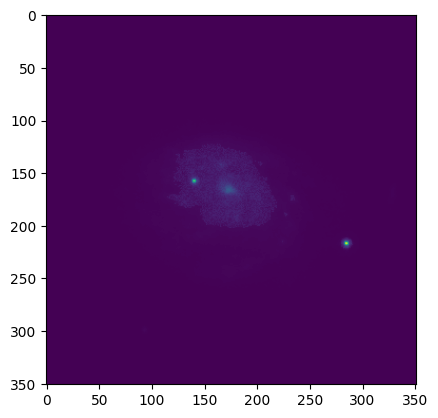

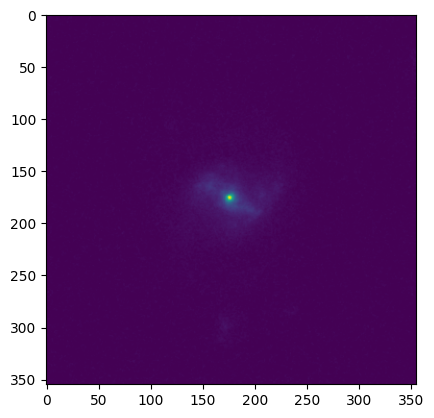

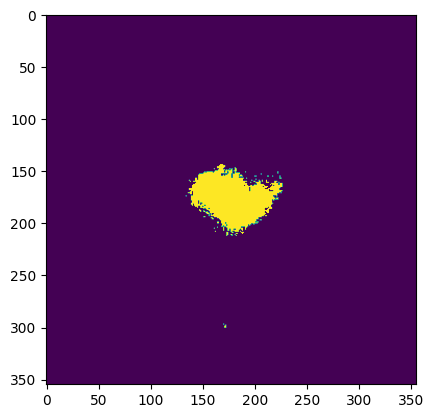

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct cl

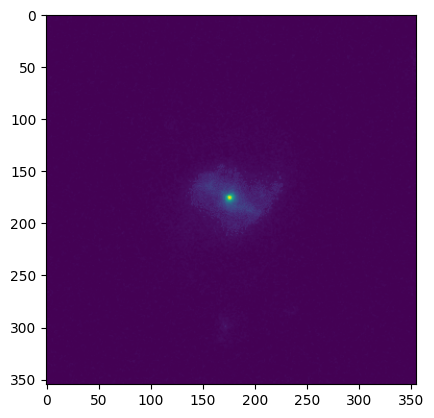

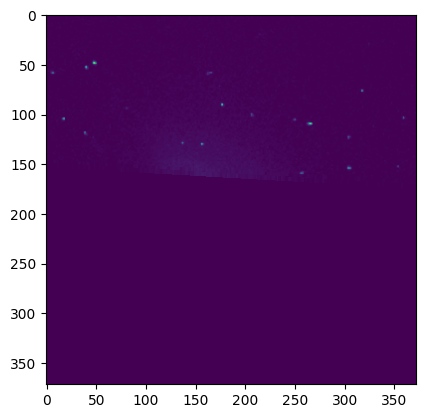

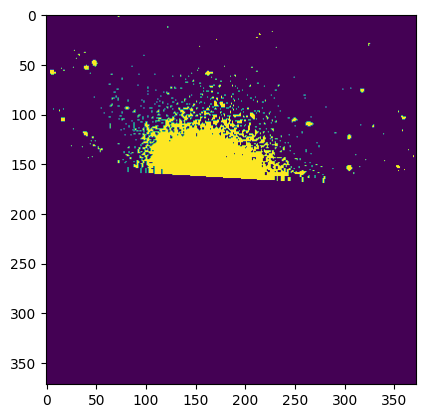

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct cl

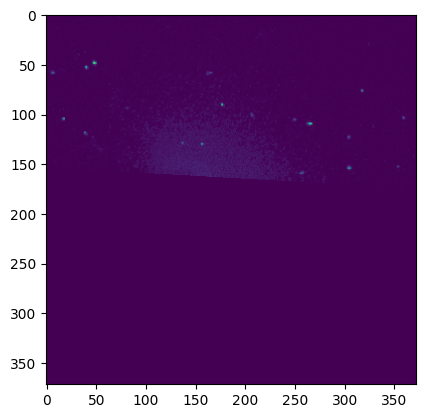

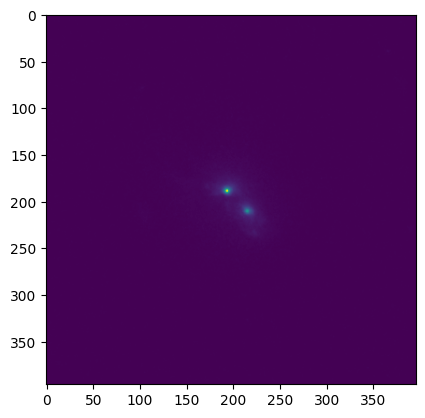

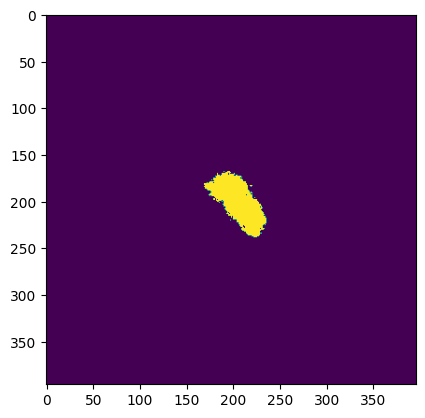

/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)
/tmp/ipykernel_329616/282563233.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(data)


Distribution of SSIM values:
Max SSIM value:  0.9999996
Min SSIM value:  0.92679054
Mean SSIM value:  0.9970582
Distribution of SSSIM values:
Max SSSIM value:  0.99833345
Min SSSIM value:  0.7008343
Mean SSSIM value:  0.94202906


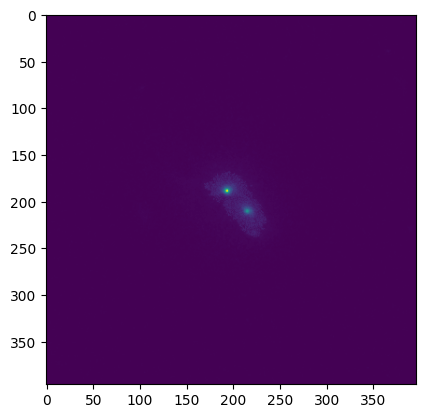

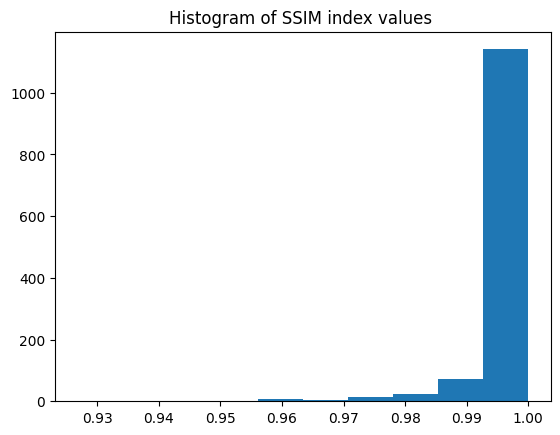

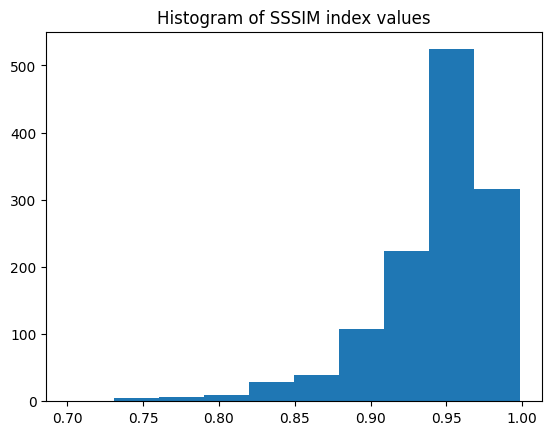

In [10]:
# compare ssim values

ind = 0

random.seed(23)

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.fits'):
    # load image
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val != 0:
        imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
        imarray = imarray.numpy()

    # create array that has brightness value for each pixel 
    data = imarray.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': imarray.flatten(),
                           'label': kmeans.labels_})
    
    if len(np.unique(kmeans.labels_)) == 1:
        continue
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(imarray.shape)
    labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    weighted_array = detailed_array

    # create modified image in detailed areas 
    modified_array = (np.random.rand(weighted_array.shape[0], weighted_array.shape[1])*0.05 
                      + imarray) * detailed_array + imarray * background_array
    modified_array[modified_array > np.max(modified_array)] = np.max(modified_array)

    
    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    modified_array = modified_array.reshape(modified_array.shape[0], modified_array.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray), 
                         torch.Tensor(modified_array), 
                         val_range=np.max(modified_array)-np.min(modified_array)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                   torch.Tensor(modified_array), 
                                   val_range=np.max(modified_array)-np.min(modified_array), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

    ssim_vals_selected.append(ssim_val_selected)
    ssim_vals_full.append(ssim_val)
    
    if ind in [200,400,600,800,1000,1200]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(detailed_array)
        plt.show()
        plt.figure()
        plt.imshow(modified_array)
    

    ind += 1

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

# save values in csv files
ssim_added_vals_df = pd.DataFrame(ssim_vals_full)
ssim_added_vals_df.to_csv('2d_ssim_added_vals.csv') 
sssim_added_vals_df = pd.DataFrame(ssim_vals_selected)
sssim_added_vals_df.to_csv('2d_sssim_added_vals.csv') 


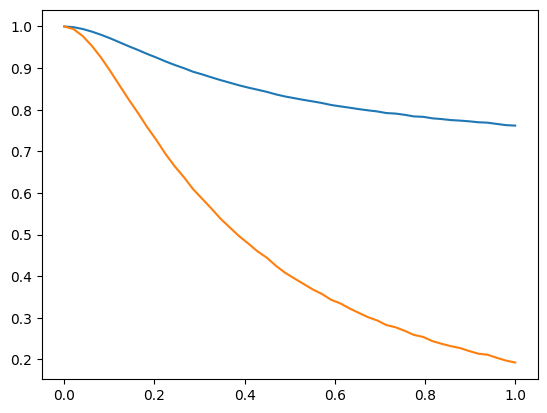

In [4]:
filename = '/home/julia/20005425.fits'

ssim_vals = []
sssim_vals = []

random.seed(23)

pixel_intensity = np.linspace(0,1,50)

# load image
image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()

# create array that has brightness value for each pixel 
data = imarray.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
kmeans.fit(data)
df = pd.DataFrame({'brightness': imarray.flatten(),
                    'label': kmeans.labels_})
    
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(imarray.shape)
labels = kmeans.labels_.reshape(imarray.shape[0],imarray.shape[1])
background_array = 1 * (labels == background_label)
detailed_array = 1*(labels != background_label)
weighted_array = detailed_array
for pixel in pixel_intensity:
    modified_array = (np.random.rand(weighted_array.shape[0], weighted_array.shape[1])*pixel
                      + imarray) * detailed_array + imarray * background_array
    modified_array[modified_array > np.max(modified_array)] = np.max(modified_array)

    imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    modified_array = modified_array.reshape(modified_array.shape[0], modified_array.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray_temp), 
                         torch.Tensor(modified_array), 
                         val_range=np.max(modified_array)-np.min(modified_array)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                   torch.Tensor(modified_array),
                                   val_range=np.max(modified_array)-np.min(modified_array), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(pixel_intensity, ssim_vals)
plt.plot(pixel_intensity, sssim_vals)

# save values in csv files
ssim_added_example_df = pd.DataFrame(ssim_vals)
ssim_added_example_df.to_csv('2d_ssim_added_exp.csv') 
sssim_added_example_df = pd.DataFrame(sssim_vals)
sssim_added_example_df.to_csv('2d_sssim_added_exp.csv')



## Background Detection on RGB Data Set - Mean Value Threshold

### Blurring

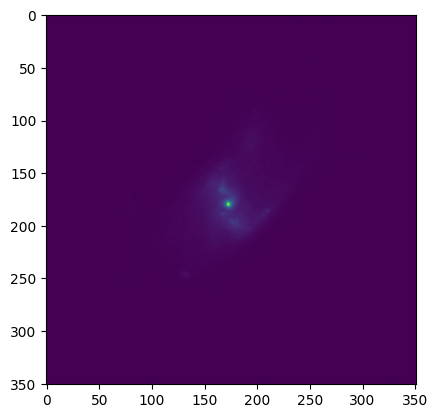

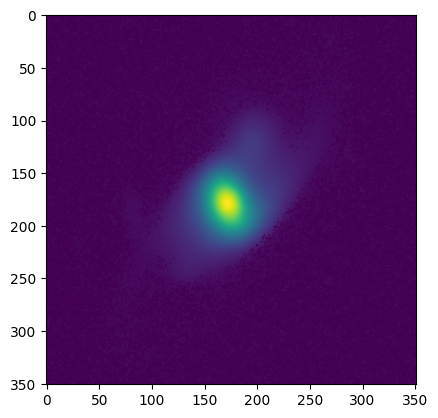

SSIM value:  tensor(0.9976)
Selecive SSIM value:  tensor(0.9846)


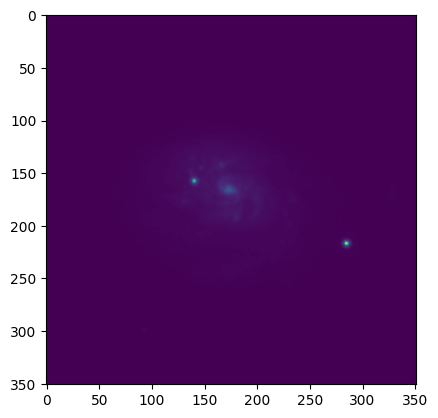

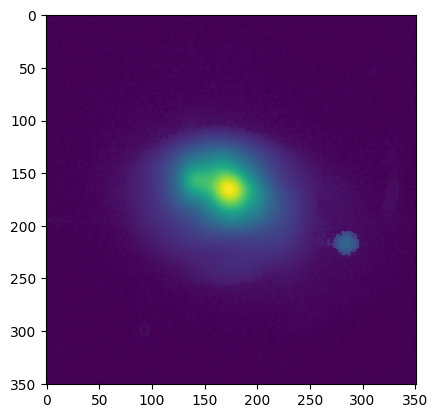

SSIM value:  tensor(0.9973)
Selecive SSIM value:  tensor(0.9858)


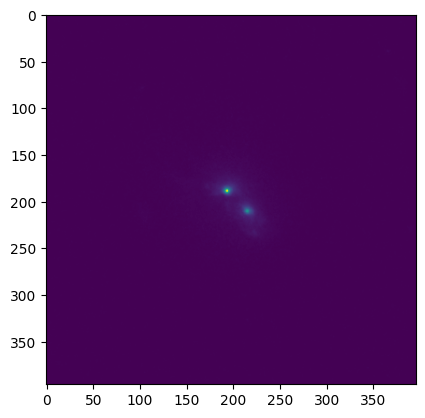

SSIM value:  tensor(0.9970)
Selecive SSIM value:  tensor(0.9886)
Distribution of SSIM values:
Max SSIM value:  0.9998517
Min SSIM value:  0.88863564
Mean SSIM value:  0.99169457
Distribution of SSSIM values:
Max SSSIM value:  0.9977117
Min SSSIM value:  0.1206144
Mean SSSIM value:  0.9678835


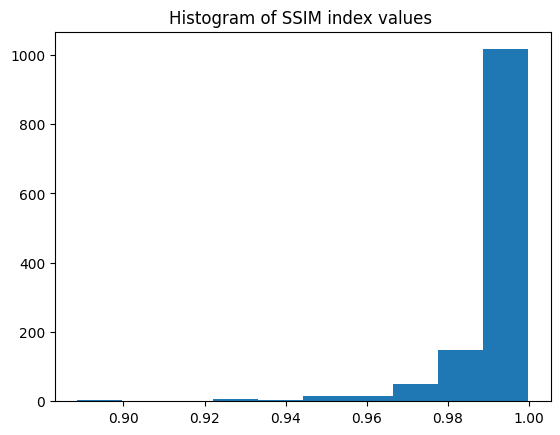

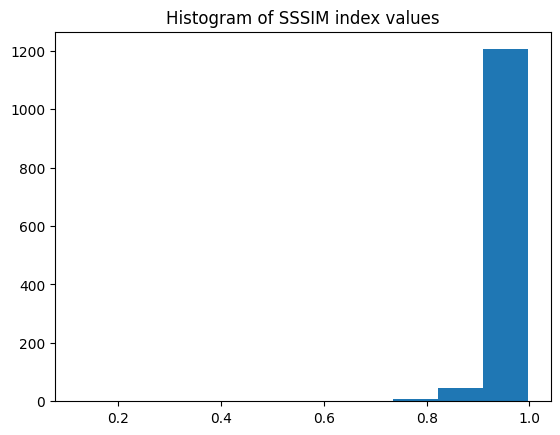

In [8]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

zero_array = 0

for filename in glob.glob('/home/julia/*.fits'):
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val != 0:
        imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
        imarray = imarray.numpy()
    
    # segment image by creating np.array that has 1s wherever 
    # at least one of RGB values is above image pixel mean for detailed are
    # and creating np.array that has 1s whereever all RGB values are below threshold
    boolean_array = 1*(imarray > imarray.mean())
    background_array = 1*(imarray <= imarray.mean())
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array
    
    if np.count_nonzero(weighted_array) == 0:
        zero_array += 1
        continue
        
    
    # create blurred image by applying gaussian blur to pixels where at least one RGB value is above threshold
    # and merging it with regular background pixels in areas where all RGB values are below threshold
    blurred = gaussian_filter(imarray, sigma=10) * boolean_array + background_im
    
    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    blurred = blurred.reshape(blurred.shape[0], blurred.shape[1], 1)
    # calculate different ssim values
    ssim_val_full = ssim_func(torch.Tensor(imarray),
                              torch.Tensor(blurred), 
                              val_range=np.max(blurred)-np.min(blurred))   
    ssim_vals_full.append(ssim_val_full)
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                   torch.Tensor(blurred), 
                                   val_range=np.max(blurred)-np.min(blurred), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))
    ssim_vals_selected.append(ssim_val_selected)

    if ind in [200, 600, 1200, 2000]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(blurred)
        plt.show()

        print("SSIM value: ", ssim_val_full)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    ind += 1

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals_full)
ssim_blurred_df.to_csv('2d_ssim_blurred_mean_val.csv') 
sssim_blurred_df = pd.DataFrame(ssim_vals_selected)
sssim_blurred_df.to_csv('2d_sssim_blurred_mean_val.csv') 

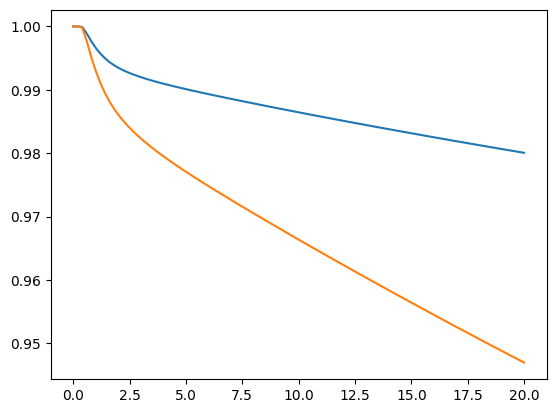

In [9]:
filename = '/home/julia/20005425.fits'

ssim_vals = []
sssim_vals = []

gaussian_blur = np.linspace(0,20,100)

image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()

# segment image by creating np.array that has 1s wherever 
# at least one of RGB values is above image pixel mean for detailed are
# and creating np.array that has 1s whereever all RGB values are below threshold
boolean_array = 1*(imarray > imarray.mean())
background_array = 1*(imarray <= imarray.mean())
segmented_im = imarray * boolean_array
background_im = imarray * background_array
# create weighted array in right shape
weighted_array = boolean_array
    
for blur in gaussian_blur:
    #create blurred image in detailed areas 
    blurred = gaussian_filter(imarray, sigma=blur) * boolean_array + imarray * background_array
    
    imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    blurred = blurred.reshape(blurred.shape[0], blurred.shape[1], 1)
    # calculate different ssim scores
    ssim_val_full = ssim_func(torch.Tensor(imarray_temp),
                              torch.Tensor(blurred), 
                              val_range=np.max(blurred)-np.min(blurred))   
    ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                   torch.Tensor(blurred), 
                                   val_range=np.max(blurred)-np.min(blurred), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))
    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val_full)

plt.plot(gaussian_blur, ssim_vals)
plt.plot(gaussian_blur, sssim_vals)

# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals)
ssim_blurred_df.to_csv('2d_ssim_blurred_mean_exp_val.csv') 
sssim_blurred_df = pd.DataFrame(sssim_vals)
sssim_blurred_df.to_csv('2d_sssim_blurred_exp_mean_val.csv') 


### Sharpening

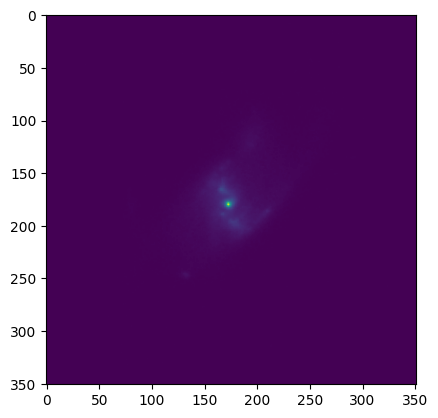

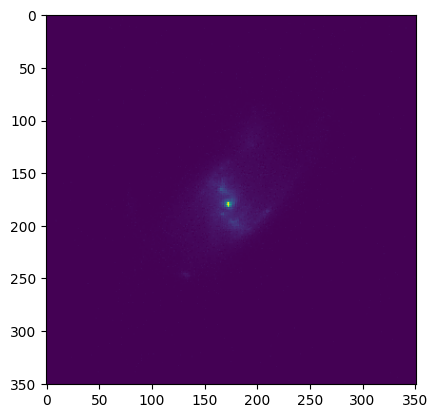

SSIM value:  tensor(0.9676)
Selecive SSIM value:  tensor(0.9362)


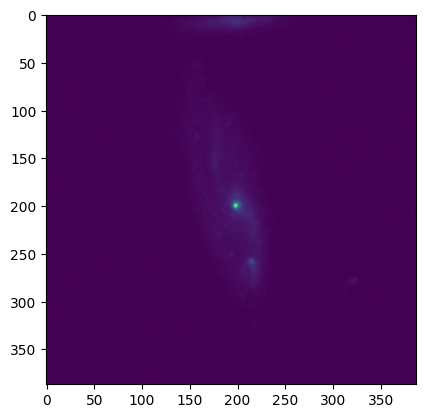

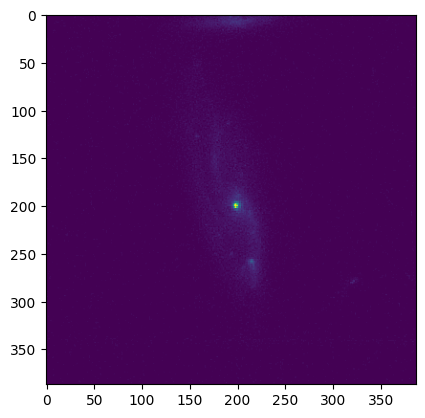

SSIM value:  tensor(0.8777)
Selecive SSIM value:  tensor(0.8163)


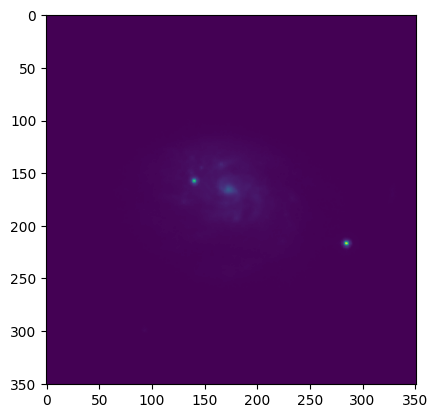

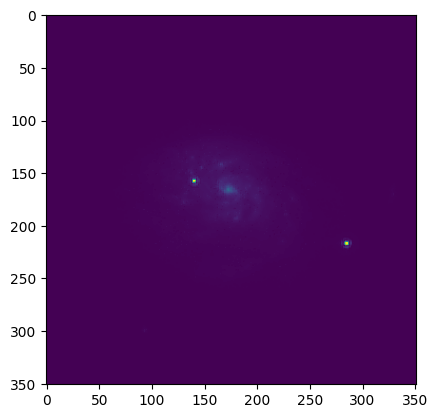

SSIM value:  tensor(0.9975)
Selecive SSIM value:  tensor(0.9869)


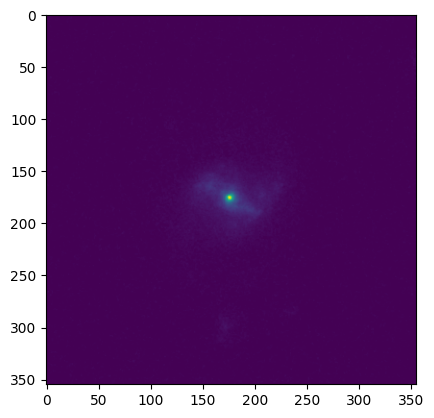

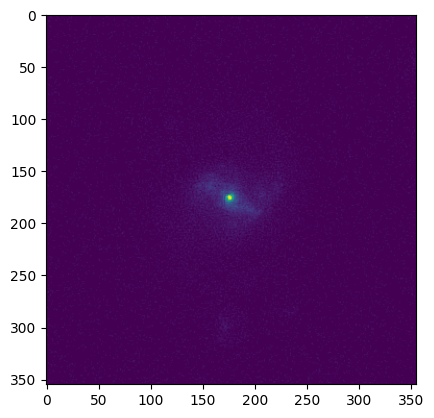

SSIM value:  tensor(0.7381)
Selecive SSIM value:  tensor(0.6925)


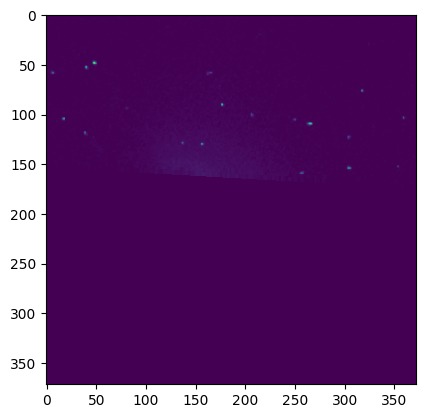

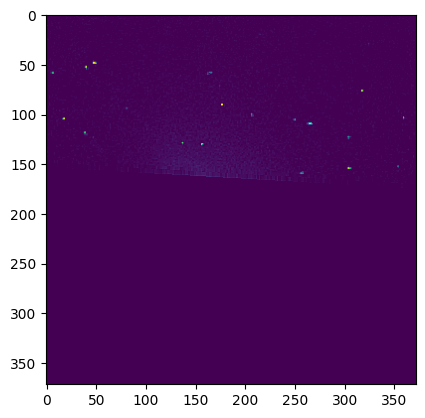

SSIM value:  tensor(0.8894)
Selecive SSIM value:  tensor(0.7612)


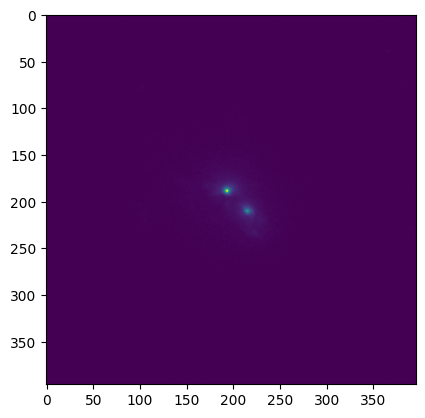

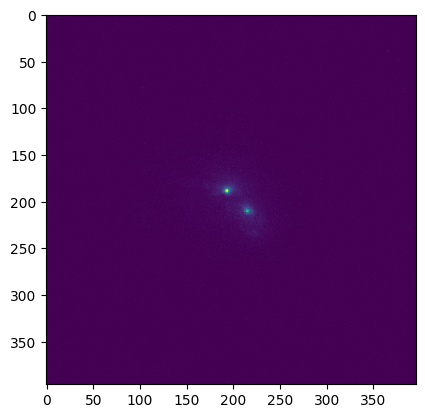

SSIM value:  tensor(0.7686)
Selecive SSIM value:  tensor(0.7608)
Distribution of SSIM values:
Max SSIM value:  0.99990577
Min SSIM value:  0.6427833
Mean SSIM value:  0.88296676
Distribution of SSSIM values:
Max SSSIM value:  0.998041
Min SSSIM value:  0.61382806
Mean SSSIM value:  0.8283996


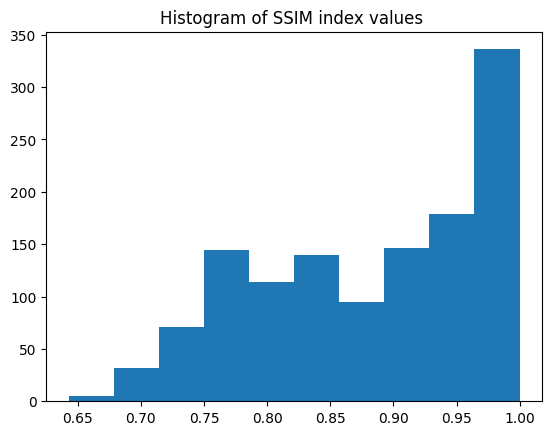

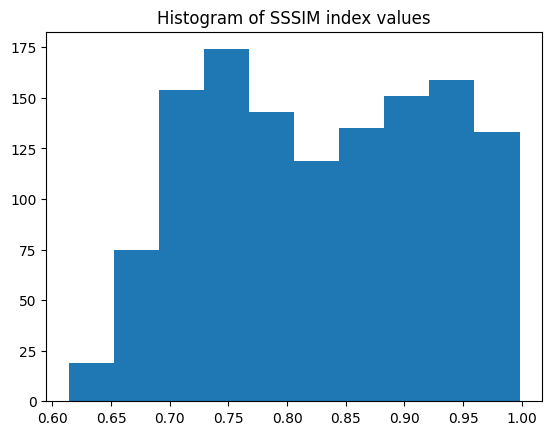

In [4]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.fits'):
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    if max_val != 0:
        imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
        imarray = imarray.numpy()

    boolean_array = 1*(imarray > imarray.mean())
    background_array = 1*(imarray <= imarray.mean())
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array
    
    if np.count_nonzero(weighted_array) == 0:
        continue
    
    # create sharpened image in detailed areas 
    im = Image.fromarray(np.uint8(imarray * 255) , 'L')
    imarray = np.array(im)

    enhancer = ImageEnhance.Sharpness(im)
    factor = 5
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * boolean_array + imarray * background_array
        
    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    sharpened = sharpened.reshape(sharpened.shape[0], sharpened.shape[1], 1)
    # calculate different ssim scores
    ssim_val_full = ssim_func(torch.Tensor(imarray),
                              torch.Tensor(sharpened), 
                              val_range=np.max(sharpened)-np.min(sharpened))   
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                   torch.Tensor(sharpened), 
                                   val_range=np.max(sharpened)-np.min(sharpened), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))
    ssim_vals_selected.append(ssim_val_selected)
    ssim_vals_full.append(ssim_val_full)

    if ind in [200, 400, 600, 800, 1000, 1200]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(sharpened)
        plt.show()

        print("SSIM value: ", ssim_val_full)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    ind += 1

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

# save values in csv files
ssim_sharpened_df = pd.DataFrame(ssim_vals_full)
ssim_sharpened_df.to_csv('2d_ssim_sharpened_mean_val.csv') 
sssim_sharpened_df = pd.DataFrame(ssim_vals_selected)
sssim_sharpened_df.to_csv('2d_sssim_sharpened_mean_val.csv') 

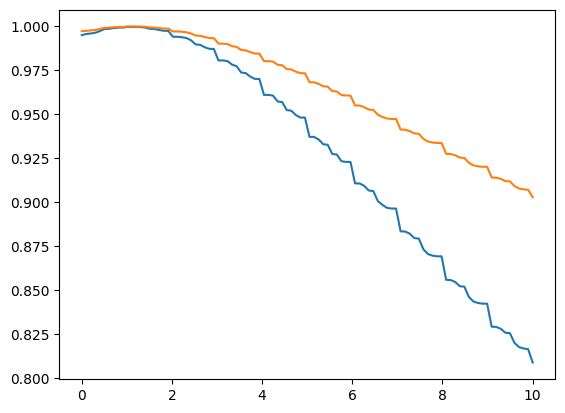

In [7]:
filename = '/home/julia/20005425.fits'

ssim_vals_selected = []
ssim_vals_full = []

sharpness = np.linspace(0,10,100)

image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()
    
boolean_array = 1*(imarray > imarray.mean())
background_array = 1*(imarray <= imarray.mean())

# create weighted array in right shape
weighted_array = boolean_array

im = Image.fromarray(np.uint8(imarray * 255) , 'L')
imarray = np.array(im)
enhancer = ImageEnhance.Sharpness(im)

for s in sharpness:
    #create sharpened image in detailed areas 
    factor = s
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * boolean_array + imarray * background_array

    imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    sharpened = sharpened.reshape(sharpened.shape[0], sharpened.shape[1], 1)
    
    # calculate different ssim scores
    ssim_val_full = ssim_func(torch.Tensor(imarray_temp),
                              torch.Tensor(sharpened), 
                              val_range=np.max(sharpened)-np.min(sharpened))   
    ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                   torch.Tensor(sharpened), 
                                   val_range=np.max(sharpened)-np.min(sharpened), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))
    ssim_vals_selected.append(ssim_val_selected)
    ssim_vals_full.append(ssim_val_full)

plt.plot(sharpness, ssim_vals_selected)
plt.plot(sharpness, ssim_vals_full)

# save values in csv files
ssim_sharpened_df = pd.DataFrame(ssim_vals_full)
ssim_sharpened_df.to_csv('2d_ssim_sharpened_exp_mean_val.csv') 
sssim_sharpened_df = pd.DataFrame(ssim_vals_selected)
sssim_sharpened_df.to_csv('2d_sssim_sharpened_exp_mean_val.csv') 


In [8]:
print(np.random.rand(5, 5)*0.05)

[[0.00305537 0.02182099 0.03336654 0.03316984 0.04776268]
 [0.04157441 0.0372838  0.03070729 0.00022424 0.03870885]
 [0.01446867 0.04798126 0.03415574 0.04422406 0.02812234]
 [0.00317663 0.01407498 0.0315144  0.02925773 0.02927855]
 [0.04338542 0.01217962 0.02721924 0.03929564 0.03206472]]


### Adding pixel values

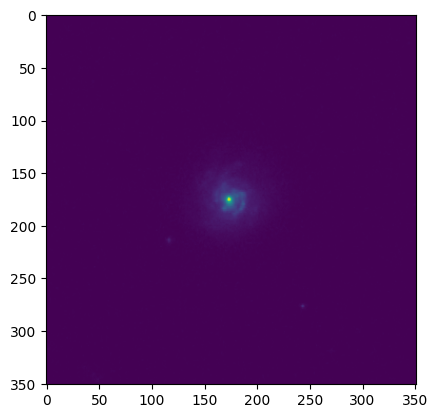

0.004673629


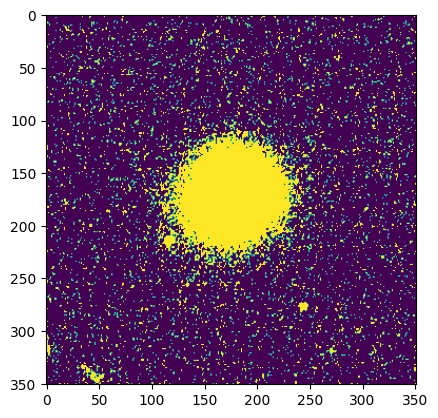

SSIM value:  tensor(0.9540)
Selecive SSIM value:  tensor(0.8120)


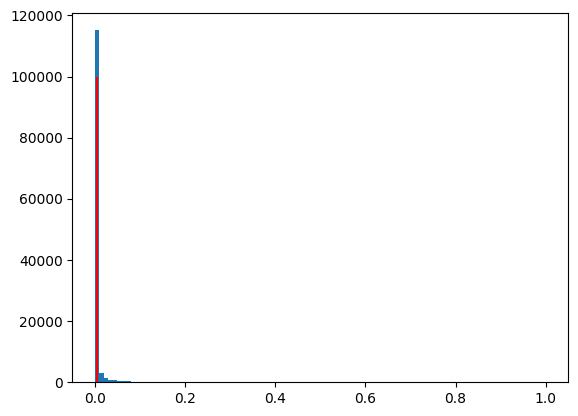

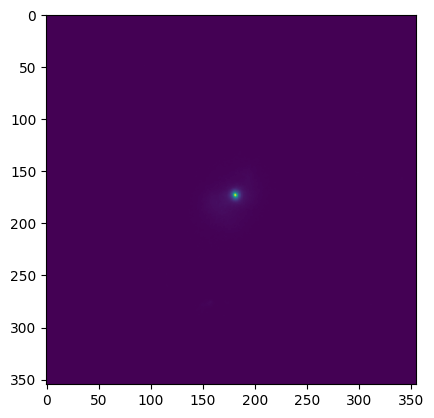

0.0012918228


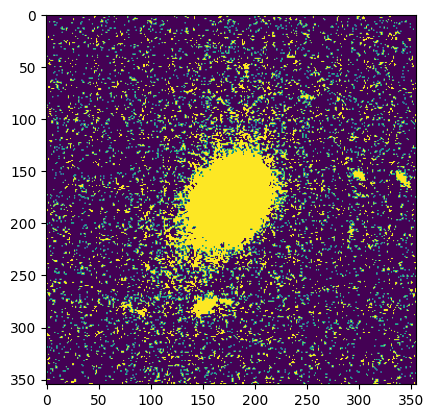

SSIM value:  tensor(0.9390)
Selecive SSIM value:  tensor(0.7670)


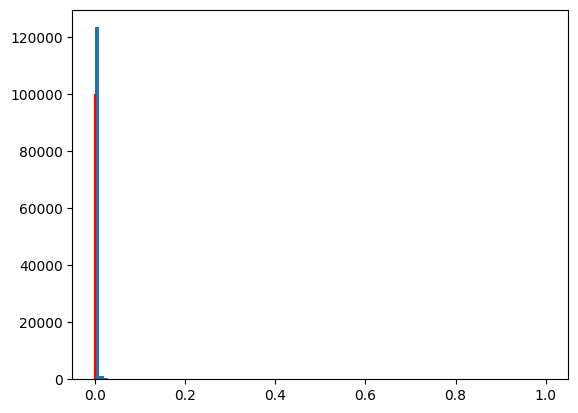

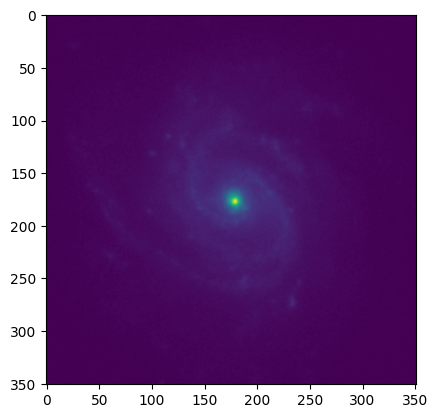

0.025346898


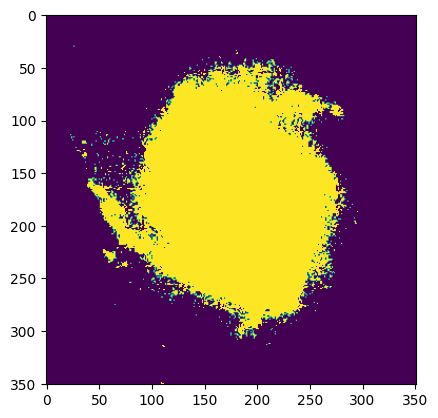

SSIM value:  tensor(0.9602)
Selecive SSIM value:  tensor(0.8784)


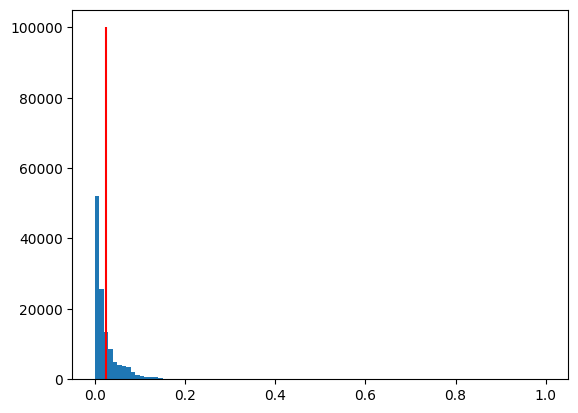

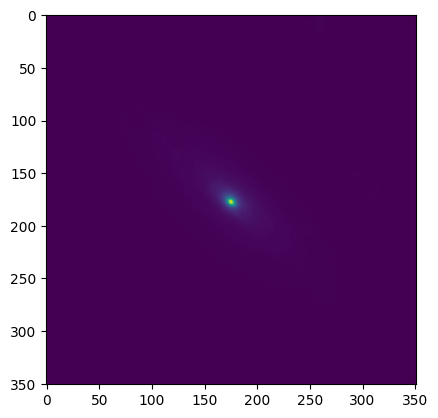

0.0035742712


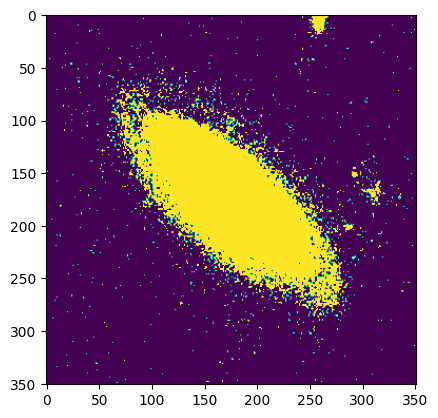

SSIM value:  tensor(0.9437)
Selecive SSIM value:  tensor(0.7193)
Distribution of SSIM values:
Max SSIM value:  nan
Min SSIM value:  nan
Mean SSIM value:  nan
Distribution of SSSIM values:
Max SSSIM value:  nan
Min SSSIM value:  nan
Mean SSSIM value:  nan


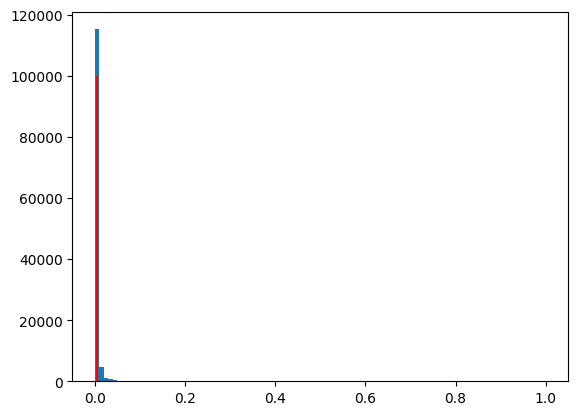

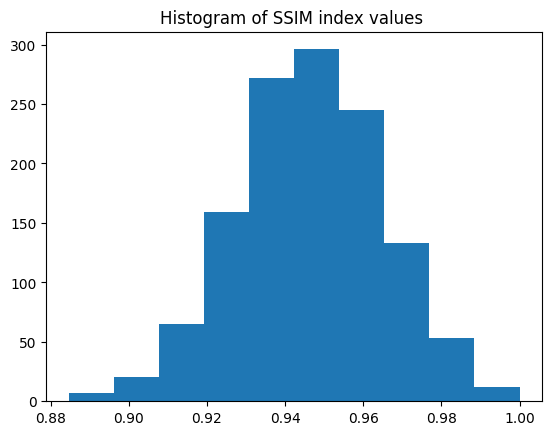

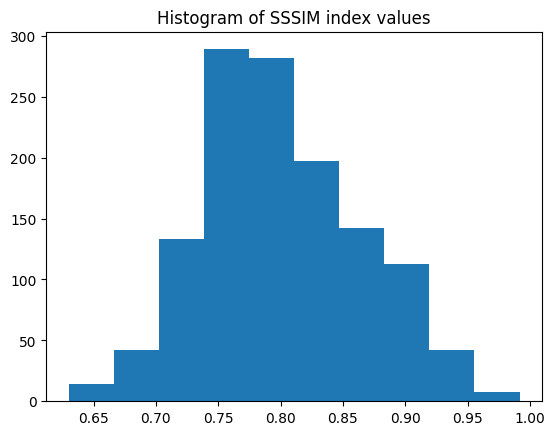

In [9]:
# compare ssim values

ind = 0

random.seed(23)

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.fits'):
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    max_val = np.max(imarray)
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()
    
    boolean_array = 1*(imarray > imarray.mean())
    background_array = 1*(imarray <= imarray.mean())
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array
    
    # create modified image in detailed areas 
    modified_array = (np.random.rand(weighted_array.shape[0], weighted_array.shape[1])*0.05 
                      + imarray) * boolean_array + imarray * background_array
    modified_array[modified_array > 1.0] = 1.0

    
    imarray = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    modified_array = modified_array.reshape(modified_array.shape[0], modified_array.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray), 
                         torch.Tensor(modified_array), 
                         val_range=np.max(modified_array)-np.min(modified_array)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray), 
                                   torch.Tensor(modified_array), 
                                   val_range=np.max(modified_array)-np.min(modified_array), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

    ssim_vals_selected.append(ssim_val_selected)
    ssim_vals_full.append(ssim_val)
    
    if ind in [200, 400, 800, 1000]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        print(imarray.mean())
        plt.figure()
        plt.imshow(boolean_array)
        plt.show()
        plt.figure()
        plt.hist(imarray.flatten(), bins=100)
        plt.vlines(imarray.mean(), ymin=0, ymax=100000, colors='red')

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    ind += 1
    
print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

# save values in csv files
ssim_added_vals_df = pd.DataFrame(ssim_vals_full)
ssim_added_vals_df.to_csv('2d_ssim_added_vals_mean_val.csv') 
sssim_added_vals_df = pd.DataFrame(ssim_vals_selected)
sssim_added_vals_df.to_csv('2d_sssim_added_vals_mean_val.csv') 


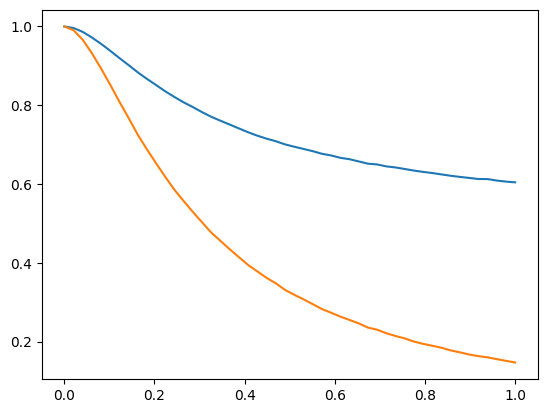

In [6]:
filename = '/home/julia/20005425.fits'

random.seed(23)

pixel_intensity = np.linspace(0,1,50)

ssim_vals_full = []
ssim_vals_selected = []

# load image
image_file = get_pkg_data_filename(filename)
imarray = fits.getdata(image_file, ext=0)
imarray = imarray.astype(np.float32)
max_val = np.max(imarray)
if max_val != 0:
    imarray = normalize_image(torch.Tensor(imarray), max_val=max_val)
    imarray = imarray.numpy()
    
boolean_array = 1*(imarray > imarray.mean())
background_array = 1*(imarray <= imarray.mean())
segmented_im = imarray * boolean_array
background_im = imarray * background_array
# create weighted array in right shape
weighted_array = boolean_array
    
for pixel in pixel_intensity:
    # create modified image in detailed areas 
    modified_array = (np.random.rand(weighted_array.shape[0], weighted_array.shape[1])*pixel
                      + imarray) * boolean_array + imarray * background_array
    modified_array[modified_array > np.max(modified_array)] = np.max(modified_array)

    
    imarray_temp = imarray.reshape(imarray.shape[0], imarray.shape[1], 1)
    modified_array = modified_array.reshape(modified_array.shape[0], modified_array.shape[1], 1)
    # calculate different ssim scores
    ssim_val = ssim_func(torch.Tensor(imarray_temp), 
                         torch.Tensor(modified_array), 
                         val_range=np.max(modified_array)-np.min(modified_array)) 
    ssim_val_selected = sssim_func(torch.Tensor(imarray_temp), 
                                   torch.Tensor(modified_array), 
                                   val_range=np.max(modified_array)-np.min(modified_array), 
                                   weighted_array=torch.Tensor(weighted_array.reshape(weighted_array.shape[0], weighted_array.shape[1], 1)))

    ssim_vals_selected.append(ssim_val_selected)
    ssim_vals_full.append(ssim_val)

plt.plot(pixel_intensity, ssim_vals_full)
plt.plot(pixel_intensity, ssim_vals_selected)

# save values in csv files
ssim_added_vals_df = pd.DataFrame(ssim_vals_full)
ssim_added_vals_df.to_csv('2d_ssim_added_vals_exp_mean_val.csv') 
sssim_added_vals_df = pd.DataFrame(ssim_vals_selected)
sssim_added_vals_df.to_csv('2d_sssim_added_vals_exp_mean_val.csv') 
